# Predikcija cene

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
import contextily as cx
import warnings
warnings.filterwarnings('ignore')

Izbacujemo kolone id, date, lat i long a od kolone zipcode pravimo vise dummie kolonona jer je zipcode kategoricki podatak. Delimo trening i test skup u odnosu 8:2.

In [2]:
df = pd.read_csv('kc_house_data.csv')
df = pd.get_dummies(df, columns=['zipcode'])
X = df.drop(columns=['price','id','date', 'long', 'lat'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

Pravimo dva modela koristeci linearnu regresiju i gradijentni busting regresor, pa im potom poredimo srednje kvadratnu gresku i r2 ocenu.

In [3]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred_gb =  reg.predict(X_train)
y_pred_gb = reg.predict(X_test)
train_r2_lr = r2_score(y_train, y_train_pred_gb)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_r2_lr = r2_score(y_test, y_pred_gb)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_gb))

In [4]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X_train, y_train)
GBest.fit(X_train, y_train)
y_train_pred_gb =  GBest.predict(X_train)
y_pred_gb = GBest.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred_gb)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_r2 = r2_score(y_test, y_pred_gb)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

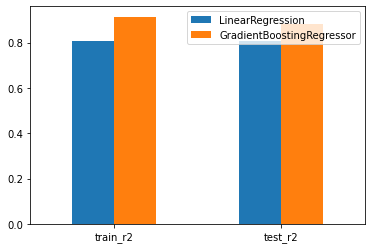

In [5]:
d = pd.DataFrame([[train_r2_lr, train_r2], [test_r2_lr, test_r2]], 
                 ["train_r2", "test_r2"], ["LinearRegression","GradientBoostingRegressor"])
ax = d.plot.bar(rot=0)
plt.show()

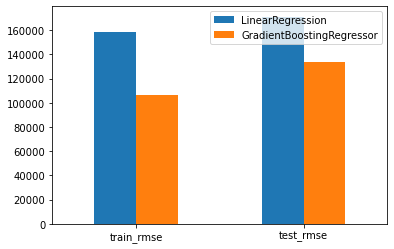

In [6]:
d = pd.DataFrame([[train_rmse_lr, train_rmse], [test_rmse_lr, test_rmse]], 
                 ["train_rmse", "test_rmse"], ["LinearRegression","GradientBoostingRegressor"])
ax = d.plot.bar(rot=0)
plt.show()

I na kraju prikaz apsolutne greske na mapi.

In [7]:
crs = {'init': 'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(df.long,df.lat)]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df_wm = geo_df.to_crs(epsg=3857)

geo_df_wm['price_error_lr'] = abs(geo_df['price'] - reg.predict(X))
geo_df_wm['price_error'] = abs(geo_df['price'] - GBest.predict(X))

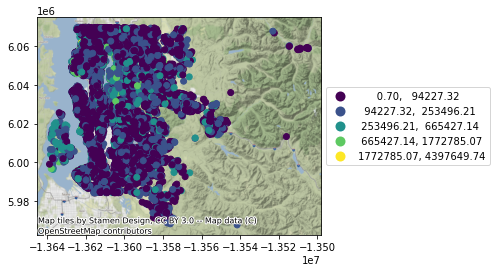

In [10]:
ax = geo_df_wm.plot(
    column = 'price_error_lr',
    scheme="naturalbreaks",
    k = 5,
    legend=True,
    legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)}
)
cx.add_basemap(ax)

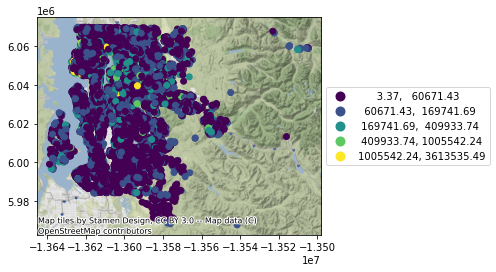

In [11]:
ax = geo_df_wm.plot(
    column = 'price_error',
    scheme="naturalbreaks",
    k = 5,
    legend=True,
    legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)}
)
cx.add_basemap(ax)